<a href="https://colab.research.google.com/github/thanhtruchhh/RFM_Analysis/blob/main/RFM_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare a dataset

## Import packages and load data

In [ ]:
!pip install squarify

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import squarify
%matplotlib inline

In [ ]:
# Load data
path = '/content/drive/MyDrive/Dataset/DACK16/RFMAnalysis/ecommerce retail.xlsx'
xlsx = pd.ExcelFile(path)
sales = pd.read_excel(xlsx, 0)

In [ ]:
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Explore data

In [ ]:
sales.shape

(541909, 8)

In [ ]:
sales.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
sales.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [ ]:
sales.duplicated().sum()

5268

In [ ]:
sales.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
print(sales['InvoiceDate'].min(), sales['InvoiceDate'].max())

2010-12-01 08:26:00 2011-12-09 12:50:00


* Dataset includes 541909 rows, 8 columns containing transaction information spanning one year, from Dec 1, 2010, to Dec 9, 2011.
* There are some missing values in the **Description** (1454) and **CustomerID** (135080) columns.
* There are 5268 duplicate records.
* The **Quantity** and **UnitPrice** columns contain negative values. This is noteworthy.
* The data types for **InvoiceNo**, **CustomerID** are incorrect.





## Clean data

With the available data and context, it is impossible to impute values for about 135k rows where **CustomerID** is `NULL` &rarr; Remove these rows.

In [ ]:
# Remove missing values in CustomerID
sales = sales[sales['CustomerID'].notna()]
sales.shape

(406829, 8)

In [ ]:
sales.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

After dropping missing values in the **CustomerID** column, missing values in the **Description** column are also removed.

Then, drop duplicate rows.

In [ ]:
# Remove duplicates
sales = sales.drop_duplicates()
sales.shape

(401604, 8)

Next, address irregular values in the **UnitPrice** and **Quantity** columns.

In [ ]:
# Check again UnitPrice, Quantity columns
print((sales['UnitPrice'] < 0).sum(), (sales['Quantity'] <= 0).sum())

0 8872


In [ ]:
# Remove rows contian Quantity <= 0
sales = sales[sales['Quantity'] > 0]
sales.shape

(392732, 8)

Cancelled transaction codes start with 'C' letter &rarr; Remove all them.

In [ ]:
# Check if dataset contains cancelled order (InvoiceNo starts with 'C')
(sales['InvoiceNo'].astype(str).str[0] == 'C').sum()

0

All cancelled orders were removed in the previous steps.

Convert **InvoiceNo** and **CustomerID** to the appropriate data types.

In [ ]:
# Convert InvoiceNo to int
sales['InvoiceNo'] = sales['InvoiceNo'].astype(int)

# Convert CustomerID to int
sales['CustomerID'] = sales['CustomerID'].astype(int)

# Segment customers

## Build a RFM model

Determine how to calculate and compute the R, F, and M scores for each customer.

*Note: The calculation date for the R score is set to December 31, 2011.*

*   **R**:
  *  Choose the reference date as `31/12/2011`.
  *  Identify the last purchase date of each customer.
  *  Calculate the number of days between the two dates.
*   **F**: Count number of orders for each customer.
*   **M**: Calculate total spend for each customer.


In [ ]:
# Set reference date = 31/12/2011
ref_date = datetime.datetime(2011, 12, 31)

# Calc total line
sales['TotalLine'] = sales['Quantity'] * sales['UnitPrice']

# Calc Recency, Frequency, Monetary
rfm = sales.groupby('CustomerID', as_index = False).agg({
    'InvoiceDate' : lambda x: (ref_date - x.max()).days,
    'InvoiceNo' : 'nunique',
    'TotalLine' : 'sum'
})

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,346,1,77183.60
1,12347,23,7,4310.00
2,12348,96,4,1797.24
3,12349,39,1,1757.55
4,12350,331,1,334.40


## Compute RFM values using the quintile method

Quintiles are used to divide a dataset into five approximately equal parts, each containing 20% of the data.

To calculate RFM values, use the `qcut` method to divide the values into five bins, and then label each bins accordingly *(1 - 5)*:

* For **R_Score**: The smaller the **Recency**, the higher the score.
* For **F_Score**: The greater the **Frequency**, the higher the score.
* For **M_Score**: The larger the **Monetary** value, the higher the score.

In [ ]:
# Computing quintile of RFM values
# R score
rfm['R_Score'] = pd.qcut(rfm['Recency'],
                         q = 5,
                         labels = [5, 4, 3, 2, 1]
                         ).astype(int)

# M score
rfm['M_Score'] = pd.qcut(rfm['Monetary'],
                         q = 5,
                         labels = [1, 2, 3, 4, 5]
                         ).astype(int)

* There is an issue when applying the same method to the **Frequency** column: Bin edges are not unique.
* Solution: Use `.rank(method='first')` to rank the values of the **Frequency** column first and then use `pd.qcut` to calculate the quintile scores based on these rankings.

In [ ]:
# F score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method = 'first'), # Rank values from 1 to n. If values are equal, ranks assigned in order they appear in the array.
                         q = 5,
                         labels = False # Return only integer indicators of the bins (0, 1, 2...)
                         ) + 1

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,M_Score,F_Score
0,12346,346,1,77183.60,1,5,1
1,12347,23,7,4310.00,5,5,5
2,12348,96,4,1797.24,2,4,4
3,12349,39,1,1757.55,4,4,1
4,12350,331,1,334.40,1,2,1


In [ ]:
# Calc RFM score
rfm['RFM'] = rfm['R_Score'] * 100 + rfm['F_Score'] * 10 + rfm['M_Score']
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,M_Score,F_Score,RFM
0,12346,346,1,77183.60,1,5,1,115
1,12347,23,7,4310.00,5,5,5,555
2,12348,96,4,1797.24,2,4,4,244
3,12349,39,1,1757.55,4,4,1,414
4,12350,331,1,334.40,1,2,1,112


## Group customers into segments

Group customers based on the calculated scores using the classification table.

In [ ]:
# Load segmentation sheet
segments = pd.read_excel(xlsx, 1)
segments

,Segment,RFM Score
0,Champions,"555, 554, 544, 545, 454, 455, 445"
1,Loyal,"543, 444, 435, 355, 354, 345, 344, 335"
2,Potential Loyalist,"553, 551, 552, 541, 542, 533, 532, 531, 452, 4..."
3,New Customers,"512, 511, 422, 421, 412, 411, 311"
4,Promising,"525, 524, 523, 522, 521, 515, 514, 513, 425,42..."
5,Need Attention,"535, 534, 443, 434, 343, 334, 325, 324"
6,About To Sleep,"331, 321, 312, 221, 213, 231, 241, 251"
7,At Risk,"255, 254, 245, 244, 253, 252, 243, 242, 235, 2..."
8,Cannot Lose Them,"155, 154, 144, 214,215,115, 114, 113"
9,Hibernating customers,"332, 322, 233, 232, 223, 222, 132, 123, 122, 2..."


In [ ]:
segments['RFM Score'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 11 entries, 0 to 10
Series name: RFM Score
Non-Null Count  Dtype 
--------------  ----- 
11 non-null     object
dtypes: object(1)
memory usage: 216.0+ bytes


In [ ]:
# Check if RFM Score is str
isinstance(segments.loc[0, 'RFM Score'], str)

True

Convert comma-separated string to a list of RFM scores, then expand the list into a set of rows.

In [ ]:
# Slip cell into multiple rows
segments_new = (segments.set_index(['Segment'])
                        .apply(lambda row: row.str.split(',').explode())  # Convert RFM Score to a list, then transform each ele in the list to a row
                        .reset_index())

# Convert RFM Score to int
segments_new['RFM Score'] = segments_new['RFM Score'].astype(int)
segments_new

,Segment,RFM Score
0,Champions,555
1,Champions,554
2,Champions,544
3,Champions,545
4,Champions,454
...,...,...
120,Lost customers,112
121,Lost customers,121
122,Lost customers,131
123,Lost customers,141


In [ ]:
# Merge rfm and segemnts_new to get segment of each customer
customers = rfm.merge(segments_new,
                      how = 'left',
                      left_on = 'RFM',
                      right_on = 'RFM Score'
                )
customers = customers.drop('RFM Score', axis = 1)
customers

,CustomerID,Recency,Frequency,Monetary,R_Score,M_Score,F_Score,RFM,Segment
0,12346,346,1,77183.60,1,5,1,115,Cannot Lose Them
1,12347,23,7,4310.00,5,5,5,555,Champions
2,12348,96,4,1797.24,2,4,4,244,At Risk
3,12349,39,1,1757.55,4,4,1,414,Promising
4,12350,331,1,334.40,1,2,1,112,Lost customers
...,...,...,...,...,...,...,...,...,...
4334,18280,298,1,180.60,1,1,2,121,Lost customers
4335,18281,201,1,80.82,1,1,2,121,Lost customers
4336,18282,28,2,178.05,5,1,3,531,Potential Loyalist
4337,18283,24,16,2045.53,5,4,5,554,Champions


# Visualize and extract insights from data

* Visualize customer segmentations across various dimensions.
* Provide recommendations for the Marketing team regarding launching campaigns to thank customers for supporting the company and to exploiting potential customers to become loyal customers.
* Suggest to the Marketing and Sales team regarding the Superstore company's retail model, which of the three metrics - R, F, or M should be most interested in.

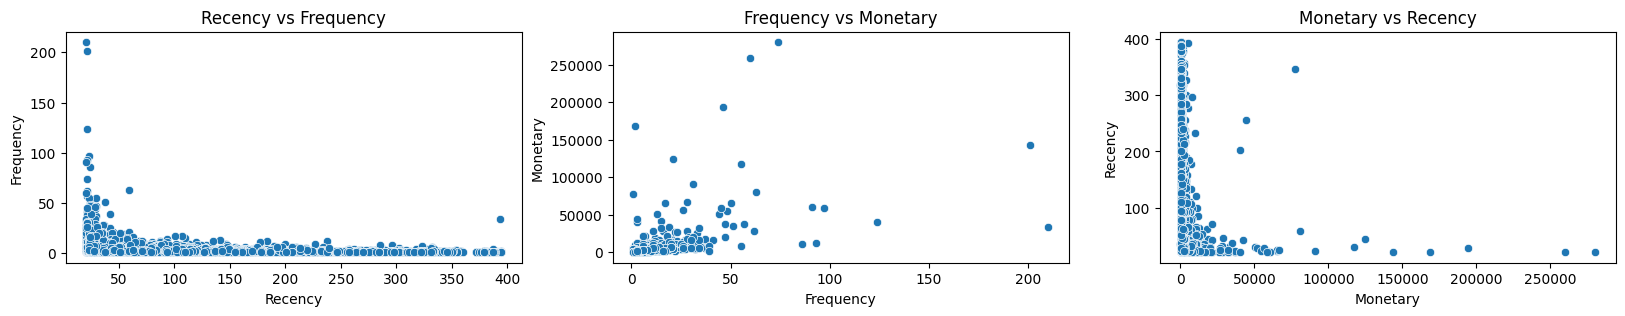

In [ ]:
# Visualize correlation of 2 variables
columns = ['Recency', 'Frequency', 'Monetary']

fig, axes = plt.subplots(1, len(columns), figsize=(20, 3))

for i, col in enumerate(columns):
  # Wrap around to the beginning of the list if i reaches the end of the list
  j = (i + 1) % len(columns)
  sns.scatterplot(data = customers, x = col, y = columns[j], ax = axes[i])
  axes[i].set_title('{} vs {}'.format(col, columns[j]))

plt.show()

* Customers who have made recent purchases also tend to be frequent buyers &rarr; There might be a relationship between recency and frequency.
* There doesn't appear to be a clear correlation between the frequency of purchases and the monetary value of customers.
* Most of the customers who made recent purchases generated higher revenue compared to customers who haven't made purchases for a while &rarr; There might be a positive correlation between recency and monetary value.

&rarr; Customers who have made recent purchases recently tend to not only be frequently buyers but also spend more. They represent potential candidates for becoming loyal customers

Text(0.5, 1.0, 'Distribution of Recency')

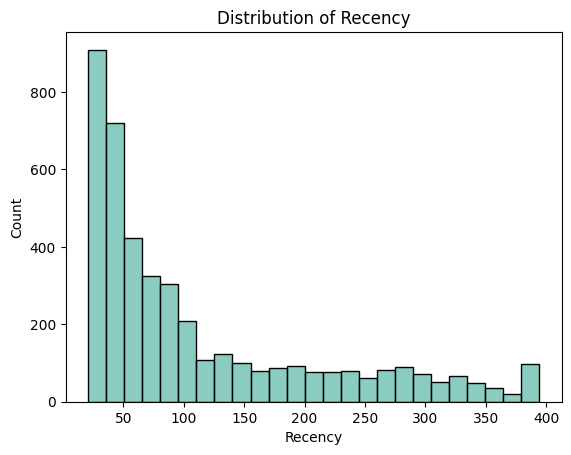

In [ ]:
sns.histplot(data = customers,
             x = 'Recency',
             color='#64bbac')
plt.title('Distribution of Recency')

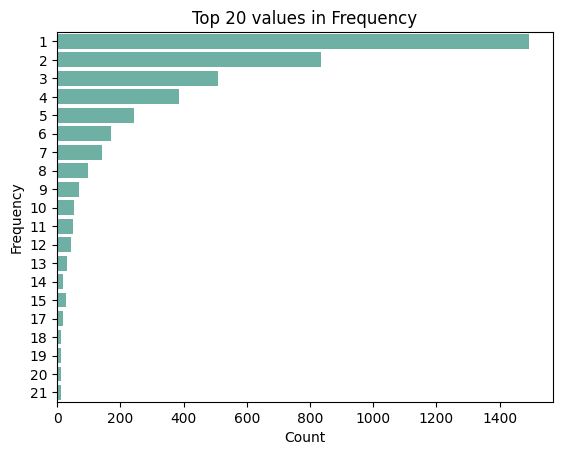

In [ ]:
# Visualize the top 20 most frequently occurring values in Frequency
top_20 = customers['Frequency'].value_counts().sort_values(ascending = False).head(20)
sns.barplot(x = top_20.values,
            y = top_20.index,
            orient = 'h',
            color='#64bbac')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Top 20 values in Frequency')

plt.show()

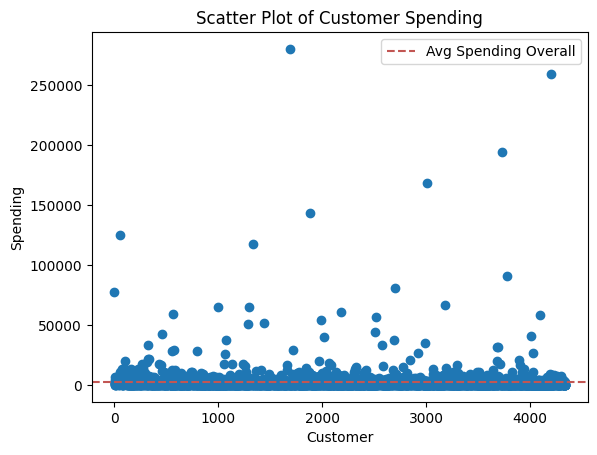

In [ ]:
avg_spending = customers['Monetary'].mean()

plt.scatter(range(len(customers['Monetary'])), customers['Monetary'])
plt.title('Scatter Plot of Customer Spending')
plt.xlabel('Customer')
plt.ylabel('Spending')
plt.axhline(y=avg_spending, color = '#c25653', linestyle='--', label='Avg Spending Overall')
plt.legend()
plt.show()

* While some customer are outstanding with very high spending, most customers tend to fall around the average spending range. There are no customers with signigiciantly lower spending than the average.
* Most customers are making only 1-2 purchases during the given one-year period, and there are relatively few customers making more than 6 purchases. In the context of the online retail industry, this suggests that customers purchase requenct is relatively low. This,coupled with the fact that most customers made their last purchase within 50 days, indicates that while the company effectively attracts only new customers &rarr; The Sales and Marketing team need to pay attention to the F metric.

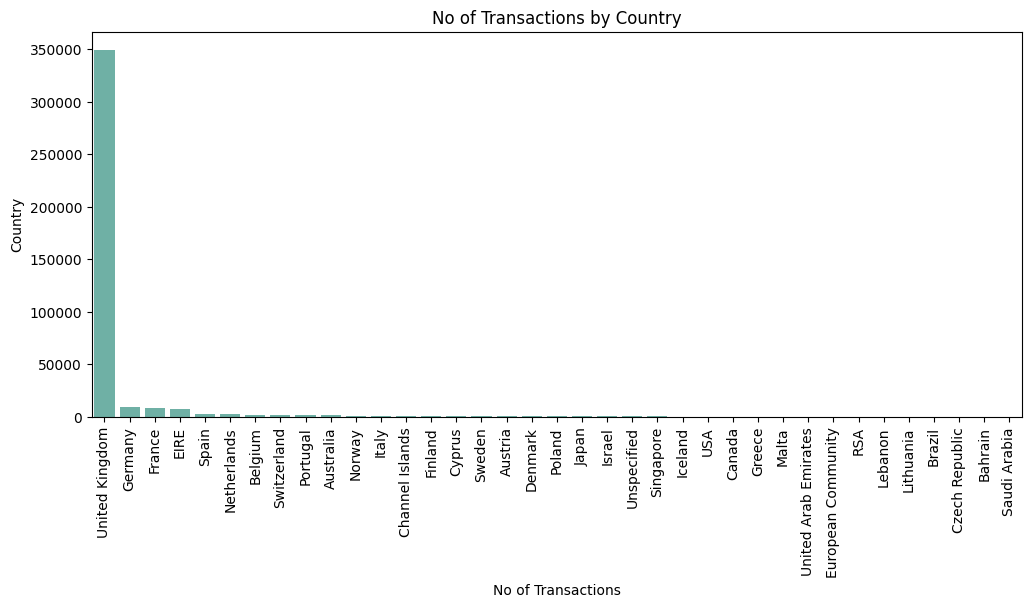

In [ ]:
sales_country = sales['Country'].value_counts().sort_values(ascending = False)

# Set the figure size
plt.figure(figsize=(12, 5))
sns.barplot(y = sales_country.values,
            x = sales_country.index,
            color='#64bbac')

plt.xticks(rotation = 90)
plt.xlabel('No of Transactions')
plt.ylabel('Country')
plt.title('No of Transactions by Country')

plt.show()

The majority of transactions are in the UK, which makes sense since the data pertains to a UK-based online retail business.

In [ ]:
# Find transactions in Nov and Dec
nov_dec_sales =  sales[sales['InvoiceDate'].dt.month.isin([11, 12])]
product_nov_dec_sales = nov_dec_sales.groupby('StockCode', as_index = False).agg({'InvoiceNo': 'nunique','Quantity': 'sum'}).rename(columns = {'InvoiceNo' : 'No_Orders', 'Quantity': 'Total_Items'})
product_nov_dec_sales['Items_per_Order'] = np.floor(product_nov_dec_sales['Total_Items'] / product_nov_dec_sales['No_Orders'])
product_nov_dec_sales.head()

,StockCode,No_Orders,Total_Items,Items_per_Order
0,10002,16,224,14.0
1,10080,6,91,15.0
2,10120,13,71,5.0
3,10125,11,231,21.0
4,10133,13,123,9.0


In [ ]:
top_15_products_by_orders = product_nov_dec_sales.sort_values(by = 'No_Orders', ascending = False).head(15)

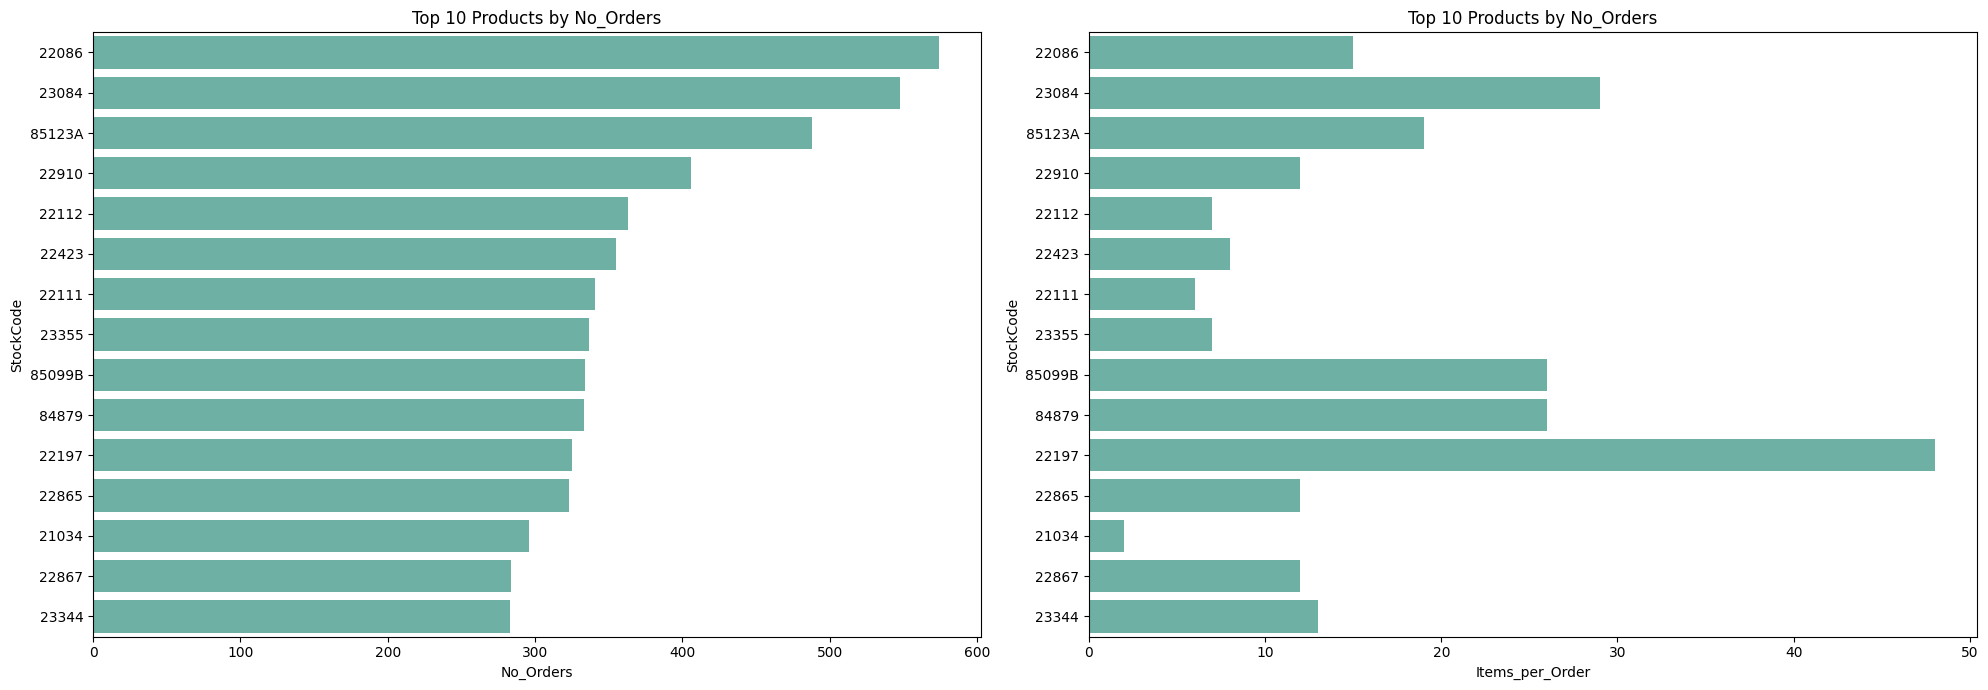

In [ ]:
# Define the columns to be used for subplots
nov_dec_columns = ['No_Orders', 'Items_per_Order']

fig, axes = plt.subplots(1, len(nov_dec_columns), figsize=(20, 7))

for i, col in enumerate(nov_dec_columns):
  sns.barplot(data = top_15_products_by_orders, x = col, y = 'StockCode', ax = axes[i], orient='h', color='#64bbac')
  axes[i].set_title('Top 10 Products by No_Orders')
  axes[i].set_xlabel(col)
  axes[i].set_ylabel('StockCode')

plt.tight_layout()
plt.show()

This is a campaign launched during the Christmas and new-year season, so we analyze transactions from November and December:
* For products that have both a high number of orders and are typically purchased in large quantities *(stockcodes 22086, 23084, 85099B, 84879, and 22197)*, creating product combos can be an effective strategy.

* For products with high order numbers but low quantities per purchase *(stockcodes 22112, 22423, 22111, 23355, and 21034)*, offering discounts or cross-selling them with similar items is a good approach.

In [ ]:
customer_segment = customers.groupby('Segment', as_index = False).agg({'CustomerID' : 'count',
                                                                       'Monetary' : 'sum',
                                                                       'Recency' : 'mean'})
customer_segment.columns = ['Segment', 'No_Customers', 'Total_Spending', 'Avg_Recency']
total_customers = customer_segment['No_Customers'].sum()
customer_segment['%_Customers'] = customer_segment['No_Customers'].apply(lambda x: round(100.0 * x / customer_segment['No_Customers'].sum(), 2))
customer_segment['Avg_Spending'] = customer_segment['Total_Spending'] / customer_segment['No_Customers']
customer_segment

,Segment,No_Customers,Total_Spending,Avg_Recency,%_Customers,Avg_Spending
0,About To Sleep,286,78743.090,106.954545,6.59,275.325490
1,At Risk,424,750887.431,164.445755,9.77,1770.960922
2,Cannot Lose Them,92,204036.680,257.728261,2.12,2217.790000
3,Champions,834,5591628.710,31.841727,19.22,6704.590779
4,Hibernating customers,693,282747.332,170.591631,15.97,408.004808
5,Lost customers,484,96341.980,296.016529,11.15,199.053678
6,Loyal,427,1016384.900,57.025761,9.84,2380.292506
7,Need Attention,286,466255.331,53.979021,6.59,1630.263395
8,New Customers,269,59674.930,48.776952,6.20,221.839888
9,Potential Loyalist,411,221408.990,47.282238,9.47,538.708005


Definition and recommended action for each customer segment:

| Segment | Characteristics | Recommendation |
| :-: | :-: | :-: |
| Champions | Bought recently, buy often and spend the most! | Reward them. Can be early adopters for new products. Will promote your brand. |
| Loyal | Spend good money with us often. Responsive to promotions. | Upsell higher value products. Ask for reviews. Engage them. |
| Potential Loyalist | Recent customers, but spent a good amount and bought more than once. | Offer membership / loyalty program, recommend other products. |
| New customers | Bought most recently, but not often. | Provide on-boarding support, give them early success, start building relationship. |
| Promising | Recent shoppers, but haven’t spent much. | Create brand awareness, offer free trials |
| Need attention | Above average recency, frequency and monetary values. May not have bought very recently though. | Make limited time offers, Recommend based on past purchases. Reactivate them. |
| About to sleep | Below average recency, frequency and monetary values. Will lose them if not reactivated. | Share valuable resources, recommend popular products / renewals at discount, reconnect with them. |
| At risk | Spent big money and purchased often. But long time ago. Need to bring them back! | Send personalized emails to reconnect, offer renewals, provide helpful resources. |
| Cannot lose them | Made biggest purchases, and often. But haven’t returned for a long time. | Win them back via renewals or newer products, don’t lose them to competition, talk to them. |
| Hibernating customers | Last purchase was long back, low spenders and low number of orders. | Offer other relevant products and special discounts. Recreate brand value. |
| Lost customers | Lowest recency, frequency and monetary scores. | Revive interest with reach out campaign, ignore otherwise. |

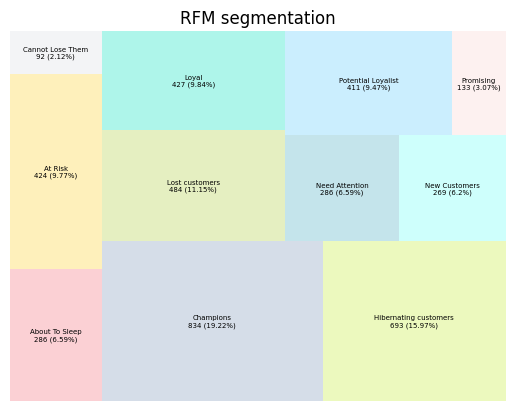

In [ ]:
colors = ['#fbd0d4', '#fef0bb', '#f3f4f6', '#d5dde8', '#ecf9be', '#e5efc1', '#aef5ea', '#c4e4eb', '#cefffc', '#cbeefe', '#fdf1f0']

# Draw the TreeMap chart
squarify.plot(sizes = customer_segment['No_Customers'],
              label = [f'{row["Segment"]}\n{row["No_Customers"]} ({row["%_Customers"]}%)' for index, row in customer_segment.iterrows()],
              color = colors,
              text_kwargs={'fontsize':5})

#Remove the axis
plt.axis('off')
plt.title('RFM segmentation')
plt.show()

The segments with the highest number of customers are as follows:
- Champions *(19.22%)*.
- Hibternating customers *(15.97%)*.
- Lost customers *(11.15%)*.
- Loyal *(9.84%)*.
- At risk *(9.77%)*.
- Potential Loyalist *(9.47%)*


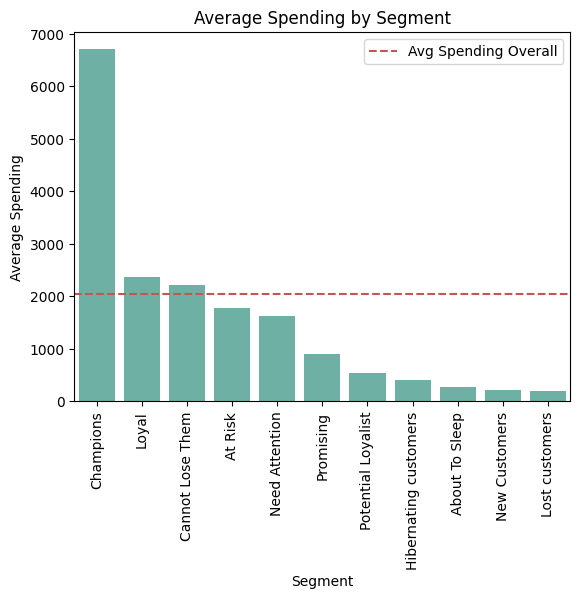

In [ ]:
sns.barplot(data = customer_segment.sort_values(['Avg_Spending'], ascending = False),
            y = 'Avg_Spending',
            x = 'Segment',
            color='#64bbac')

overall_avg_spending = plt.axhline(y=avg_spending, color = '#c25653', linestyle='--', label='Avg Spending Overall')
plt.title('Average Spending by Segment')
plt.ylabel('Average Spending')
plt.xticks(rotation = 90)

plt.legend(handles=[overall_avg_spending], labels=['Avg Spending Overall'], loc='upper right')
plt.show()

On average, each customer spends approximately $2000 on purchases at SuperStore. Among the customer segments, the three with the highest and above-average spending are:
- Champions.
- Loyal.
- Cannot lose them.

&rarr; The Marketing team should prioritize these segments for the next campaign.

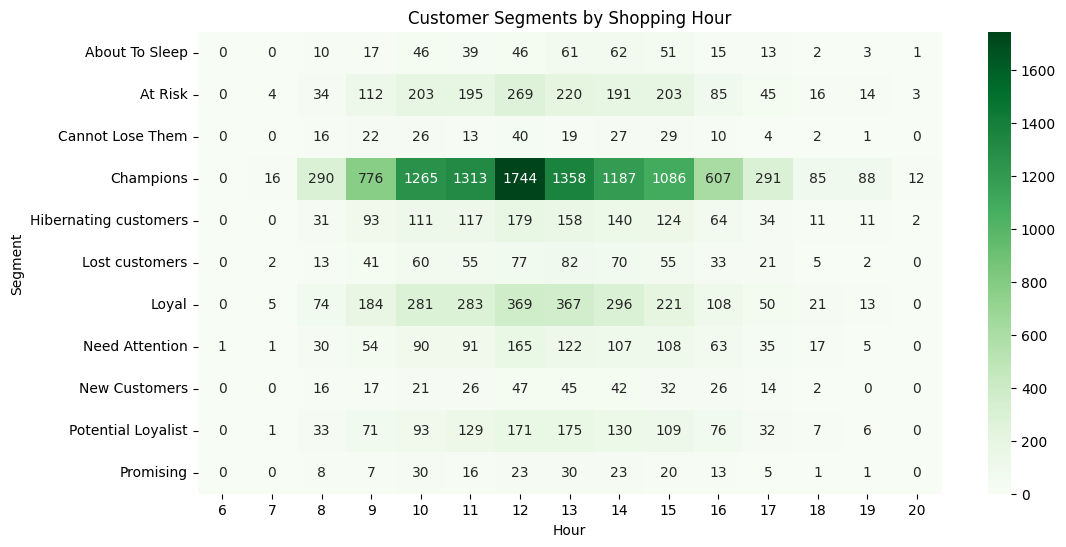

In [ ]:
sales_segment = sales.merge(customers,
                            how = 'left',
                            on = 'CustomerID')

sales_segment = sales_segment.drop(['Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM'], axis = 1)
sales_segment['Hour'] = sales_segment['InvoiceDate'].dt.hour
segment_hour = sales_segment.pivot_table(index = 'Segment', columns = 'Hour', values = 'InvoiceNo', fill_value = 0, aggfunc = 'nunique')

plt.figure(figsize=(12, 6))
sns.heatmap(segment_hour, cmap = 'Greens', annot=True, fmt='d')
plt.title('Customer Segments by Shopping Hour')
plt.xlabel('Hour')
plt.ylabel('Segment')
plt.show()

Most customers across different segments tend to shop during the midday, roughly between 10 AM and 3 PM. SuperStore can introduce special offers exclusively for this time frame to reach a larger customer base. Additionally, it's essential to ensure that the website/ mobile app can handle a high volume of users.